### Creating high-risk labels for Hubs. 

In [36]:
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

### National Covid19 Cases, Cum Cases, Deaths, Cum Deaths. 

Connect DataFrame to SQLite Database to retrieve latest data




In [37]:
cnx = sqlite3.connect('../data/hubs.db')
df = pd.read_sql_query("SELECT * FROM Covid19_Nacional_V", cnx)
df.set_index(pd.DatetimeIndex(df['report_date']), inplace=True)
df.head()

report_date  cases  cumulative_cases  deaths  cumulative_deaths
report_date                                                                
2020-01-25   2020-01-25      1                 1       0                  0
2020-01-26   2020-01-26      0                 1       0                  0
2020-01-27   2020-01-27      1                 2       0                  0
2020-01-28   2020-01-28      1                 3       0                  0
2020-01-29   2020-01-29      0                 3       0                  0

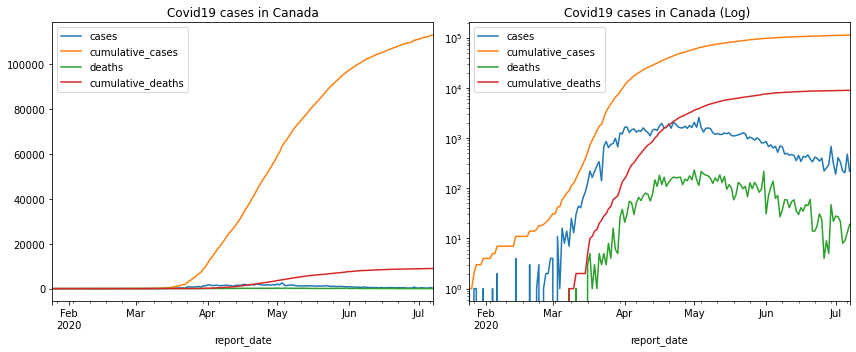

In [38]:
#Plotting National Cases, normal + log scale
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))  # 1 row, 2 columns
df.plot(title='Covid19 cases in Canada', ax=ax1)
df.plot(title='Covid19 cases in Canada (Log) ', ax=ax2, logy=True)
plt.tight_layout() 



### Retrieve all HRs with Covid19 Data.



List all HRs with Covid19 Data. 

1. ***query_hr*** returns the total number of cases 

2. ***query_hr_norm*** returns the numbers of cases per 100k habitants. It normalizes each HR based on its total population. 


In [39]:

query_hr = """
      SELECT
                  hr.PRUID, 
                  P.NAME,
                  hr.HR_UID, hr.ENGNAME, 
                  hr.report_date, 
                  hr.cases            ,
                  hr.cumulative_cases ,
                  hr.deaths           ,
                  hr.cumulative_deaths
      FROM 
           Covid19_HR_V as hr, Provinces as P
      WHERE 
           P.PRUID = hr.PRUID 
      ORDER BY
           hr.report_date
         
"""
hr_df = pd.read_sql_query(query_hr, cnx)
hr_df.head()



PRUID                       NAME HR_UID  \
0    10  Newfoundland and Labrador   1011   
1    10  Newfoundland and Labrador   1012   
2    10  Newfoundland and Labrador   1013   
3    10  Newfoundland and Labrador   1014   
4    11       Prince Edward Island   1100   

                                       ENGNAME report_date  cases  \
0            Eastern Regional Health Authority  2020-01-25      0   
1            Central Regional Health Authority  2020-01-25      0   
2            Western Regional Health Authority  2020-01-25      0   
3  Labrador-Grenfell Regional Health Authority  2020-01-25      0   
4                         Prince Edward Island  2020-01-25      0   

   cumulative_cases  deaths  cumulative_deaths  
0                 0       0                  0  
1                 0       0                  0  
2                 0       0                  0  
3                 0       0                  0  
4                 0       0                  0

In [40]:
query_hr_norm = """
      SELECT
                  hr.PRUID, 
                  P.NAME,
                  hr.HR_UID, hr.ENGNAME, 
                  hr.report_date, 
                  (100000.0 * hr.cases            / HI.Population_rate) as cases,
                  (100000.0 * hr.cumulative_cases / HI.Population_rate) as cumulative_cases,
                  (100000.0 * hr.deaths           / HI.Population_rate) as deaths,
                  (100000.0 * hr.cumulative_deaths/ HI.Population_rate) as cumulative_deaths
      FROM 
           Covid19_HR_V as hr, Provinces as P, Health_Indicators_ODHF as HI
      WHERE 
           P.PRUID = hr.PRUID AND hr.HR_UID = HI.HR_UID 
      ORDER BY
           hr.report_date
         
"""

hr_ndf = pd.read_sql_query(query_hr_norm, cnx)
hr_ndf.head()

PRUID                       NAME HR_UID  \
0    10  Newfoundland and Labrador   1011   
1    10  Newfoundland and Labrador   1012   
2    10  Newfoundland and Labrador   1013   
3    10  Newfoundland and Labrador   1014   
4    11       Prince Edward Island   1100   

                                       ENGNAME report_date  cases  \
0            Eastern Regional Health Authority  2020-01-25    0.0   
1            Central Regional Health Authority  2020-01-25    0.0   
2            Western Regional Health Authority  2020-01-25    0.0   
3  Labrador-Grenfell Regional Health Authority  2020-01-25    0.0   
4                         Prince Edward Island  2020-01-25    0.0   

   cumulative_cases  deaths  cumulative_deaths  
0               0.0     0.0                0.0  
1               0.0     0.0                0.0  
2               0.0     0.0                0.0  
3               0.0     0.0                0.0  
4               0.0     0.0                0.0

In [41]:

## Generate a **health_region** dictionary using their region identifier (hr_uid) as key. 

health_regions = {}

print(f"{'Province':<17}           | ID   |  Data(days)| Name                      ")
print(f"---------------------------------------------------------------------------")
for name, _df in hr_df.groupby('HR_UID'):
    _df.set_index(pd.DatetimeIndex(_df['report_date']), inplace=True)
    province, hr_uid, hr_name = _df.NAME[0], name, _df.ENGNAME[0]
    health_regions[hr_uid] = (province, hr_name)
    print(f"{province:<25}   | {hr_uid} |        {_df.ENGNAME.count()} | {hr_name}  ")

Province                    | ID   |  Data(days)| Name                      
---------------------------------------------------------------------------
Newfoundland and Labrador   | 1011 |        165 | Eastern Regional Health Authority  
Newfoundland and Labrador   | 1012 |        165 | Central Regional Health Authority  
Newfoundland and Labrador   | 1013 |        165 | Western Regional Health Authority  
Newfoundland and Labrador   | 1014 |        165 | Labrador-Grenfell Regional Health Authority  
Prince Edward Island        | 1100 |        165 | Prince Edward Island  
Nova Scotia                 | 1201 |        165 | Zone 1 - Western  
Nova Scotia                 | 1202 |        165 | Zone 2 - Northern  
Nova Scotia                 | 1203 |        165 | Zone 3 - Eastern  
Nova Scotia                 | 1204 |        165 | Zone 4 - Central  
New Brunswick               | 1301 |        165 | Zone 1 (Moncton area)  
New Brunswick               | 1302 |        165 | Zone 2 (Saint John 

In [42]:

def plot_health_region(df, hr_uid):
    hr = df[hr_df.HR_UID==hr_uid]
    hr.set_index(pd.DatetimeIndex(hr['report_date']), inplace=True)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))  # 1 row, 2 columns
    hr.plot(title=f'Covid19 cases HR: {hr_uid}',ax=ax1)
    hr.plot(title=f'Covid19 cases HR: {hr_uid} (Log)',ax=ax2, logy=True)
    plt.tight_layout() 

Provide a Health Region UID: 1012


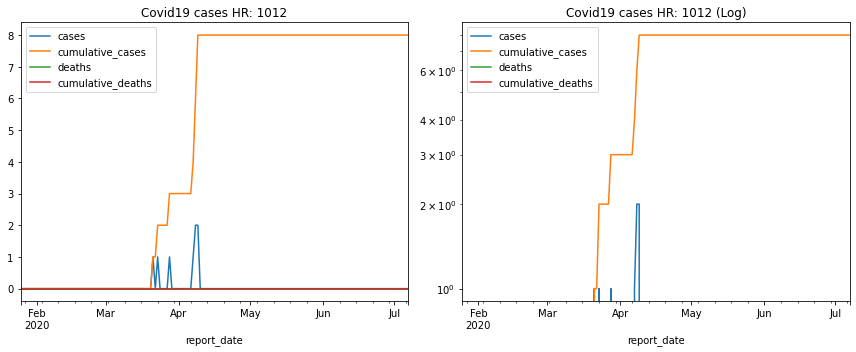

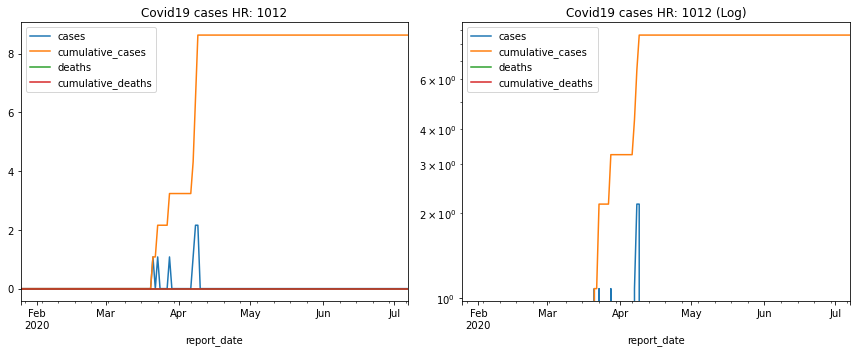

In [45]:
### National Covid19 Cases, Cum Cases, Deaths, Cum Deaths.
### Plot a Health Region by specifying its HR_UID


hr_uid = input('Provide a Health Region UID:')
plot_health_region(hr_df, hr_uid)
plot_health_region(hr_ndf, hr_uid)

### Generating HRs DataFrames based on Covid19 Data  

Generate four DataFrames (i.e., cases, cumulative cases, death, cumulative deaths) where 
each column represent a Health Region, and each row represent the report date. 
The cell values of each dataframe correspond to the value reported for each combination of report_date and HR_UID. 

Ex: 'cases' table, cX is the number of cases for region X for its corresponding date row. 


| report_date  |  HR_1  | HR_2  | ...   | HR_N  |
|---|---|---|---|---|
| YYYY-MM-DD  | c1  | c2  | ...   | cn  |



Ex: 'cumulative_cases' table, ccX is the number of cumulative cases for region X for its corresponding date row. 


| report_date  |  HR_1  | HR_2  | ...   | HR_N  |
|---|---|---|---|---|
| YYYY-MM-DD  | cc1  | cc2  | ...   | ccn  |

Ex: 'deaths' table, dX is the number of deaths for region X for its corresponding date row. 


| report_date  |  HR_1  | HR_2  | ...   | HR_N  |
|---|---|---|---|---|
| YYYY-MM-DD  | d1  | d2  | ...   | dn  |

Ex: 'cumulative_deaths' table, cdX is the number of deaths for region X for its corresponding date row. 


| report_date  |  HR_1  | HR_2  | ...   | HR_N  |
|---|---|---|---|---|
| YYYY-MM-DD  | cd1  | cd2  | ...   | cdn  |




In [46]:

keys   = ['cases', 'cumulative_cases', 'deaths', 'cumulative_deaths']

def create_df_day_hr(query, cnx):
    df3 = pd.read_sql_query(query, cnx)
  
    data   = {k: {'report_date':[]} for k in keys}

    for date, hr_df in df3.groupby('report_date'):
        for k in keys:
            data[k]['report_date'].append(date) 

        for i, row in hr_df.iterrows():
            uid = row.HR_UID
            for k in keys:
                value = row[k]
                if uid in data[k]:
                    data[k][uid].append(value)
                else:
                    data[k][uid] = [value]

    # The variable dfs will hold a dictionary of the 
    # DataFrames, the keys to acccess the DataFrames inside dfs are 
    # contained in the variable keys

    dfs    = {}
    for k in keys:
        df = pd.DataFrame (data[k], columns = data[k].keys())
        df.set_index(pd.DatetimeIndex(df['report_date']), inplace=True)
        dfs[k]   = df
    return dfs 

def plot_dataframes(dfs, columns=[], prefix='', **kargs):
    fig, axis = plt.subplots(2,2, figsize=(12,12))  # 2 row, 2 columns
    for i, k in enumerate(keys):
        df = dfs[k]
        if columns:
            df = df[columns[k]]
        df.plot(title=f'{prefix} {k}',  ax=axis[i // 2 ][i % 2], **kargs)
           

### Plotting HR Dataframes 

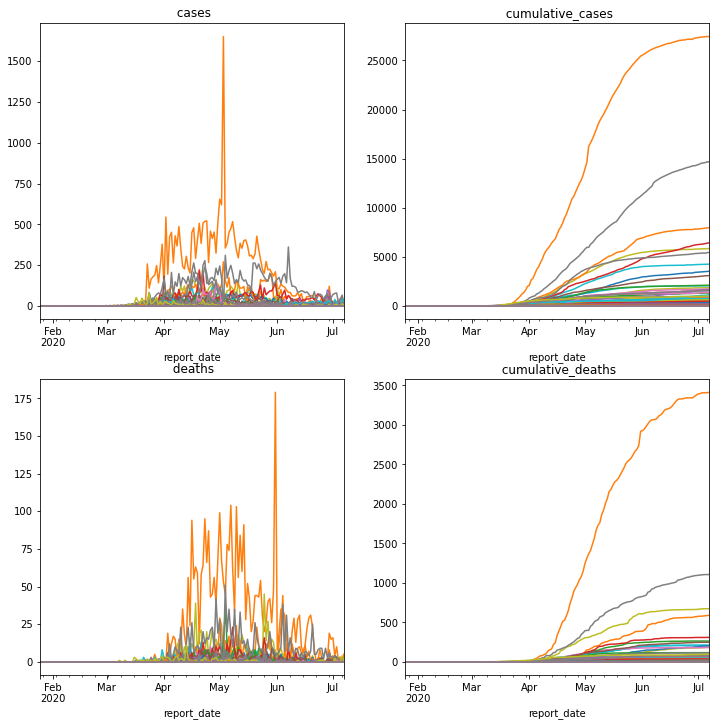

In [47]:

dfs = create_df_day_hr(query_hr, cnx)        
plot_dataframes(dfs, legend=False)




### Plotting HR Dataset. Normalized per 100k habitants 

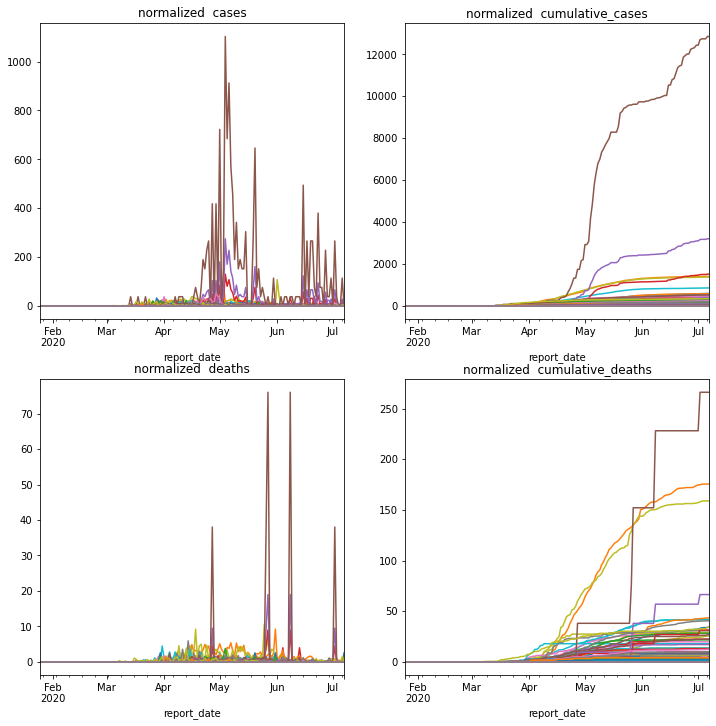

In [48]:
ndfs = create_df_day_hr(query_hr_norm, cnx)        
plot_dataframes(ndfs, prefix='normalized ' , legend=False)

### Filtering Health Regions with top maximum values

Selecting the health regions with maximum values per day.

Plotting the top X health regions with the highest value for (cases, cum cases, deaths, cum deaths). 

Maximum amount HR per day: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 2406 ('Quebec', 'Région de Montréal')
3 : 2413 ('Quebec', 'Région de Laval')
4 : 2414 ('Quebec', 'Région de Lanaudière')
5 : 4703 ('Saskatchewan', 'Cypress Regional Health Authority')
6 : 4704 ('Saskatchewan', "Regina Qu'Appelle Regional Health Authority")
7 : 4705 ('Saskatchewan', 'Sunrise Regional Health Authority')
8 : 4711 ('Saskatchewan', 'Mamawetan Churchill River Regional Health Authority')
9 : 4712 ('Saskatchewan', 'Keewatin Yatthé Regional Health Authority')
10 : 4713 ('Saskatchewan', 'Athabasca Health Authority')
11 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')


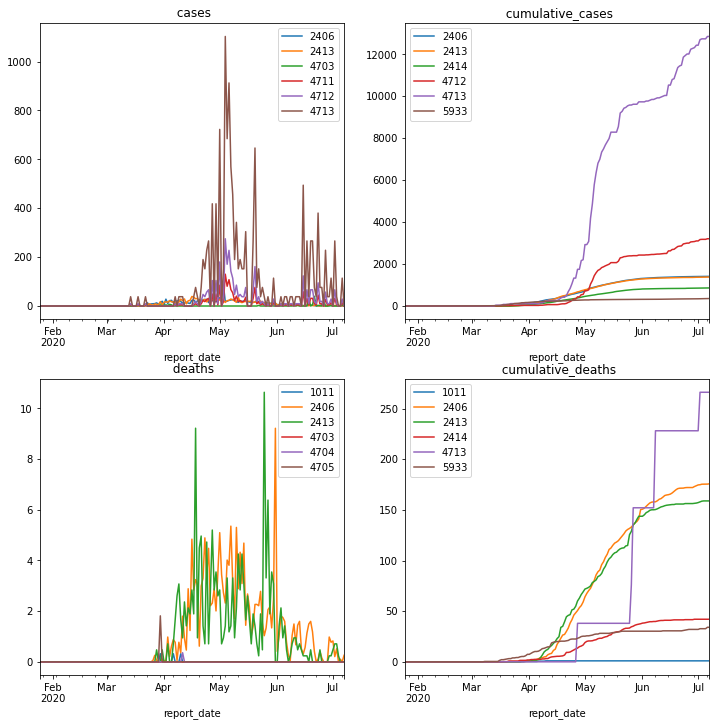

In [49]:
def display_unique_cols(columns):
    #Displaying the top Health Regions name and provinces 
    displayed = {}
    count     = 1
    
    display = []
    for k in keys:
        display.extend(columns[k])
    
    display  = sorted(list(set(display)))
    
    for uid in display:
        print(f'{count} : {uid} {health_regions[uid]}')
        count += 1
        

top = int(input('Maximum amount HR per day:'))

def filter_dfs(dfs, top, maximum_labels=top):
    columns = {}
    for key in keys:
        #get all the columns names except the report_date
        cols = dfs[key].columns[1:].tolist()
        #find the column label of the max values per row (axis=1)
        #needs to pass the name of the columns becase idxmax doesn't work with dtype object (i.e., report_date)
        #max_val_per_date = dfs[key][cols].idxmax(axis=1).tolist()
        order            = np.argsort(-dfs[key][cols].values, axis=1)[:,:top]
        headers          = dfs[key][cols].columns[order]
        labels = []
        for h in headers:
            labels.extend(h)

        counter          = Counter(labels).most_common(maximum_labels)
        columns[key]  = sorted([hr_uid for hr_uid, count in counter])
    return columns


#normalized per 100k habitants 
filtered_dfs = ndfs


#without normalization
#filtered_dfs = dfs



columns = filter_dfs(filtered_dfs, top)   
plot_dataframes(filtered_dfs,columns=columns)
display_unique_cols(columns)

### High Risk Selection

Analysis 25 Jun 2020.

## Real Data 

1. #### There are 19 top HRs with `TOP 1` reported cases
These are 19 HRs that reach a highest value of cases (and cumulatives) 
during the analyzed time frame (i.e., 26 Jan - 25 Jun 2020).


```
1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 2404 ('Quebec', 'Région de la Mauricie et du Centre-du-Québec')
3 : 2406 ('Quebec', 'Région de Montréal')
4 : 2413 ('Quebec', 'Région de Laval')
5 : 2414 ('Quebec', 'Région de Lanaudière')
6 : 2416 ('Quebec', 'Région de la Montérégie')
7 : 3530 ('Ontario', 'Durham Regional Health Unit')
8 : 3535 ('Ontario', 'Haliburton, Kawartha, Pine Ridge District Health Unit')
9 : 3542 ('Ontario', 'Lambton Health Unit')
10 : 3544 ('Ontario', 'Middlesex-London Health Unit')
11 : 3553 ('Ontario', 'Peel Regional Health Unit')
12 : 3560 ('Ontario', 'Simcoe Muskoka District Health Unit')
13 : 3570 ('Ontario', 'York Regional Health Unit')
14 : 3595 ('Ontario', 'City of Toronto Health Unit')
15 : 4832 ('Alberta', 'Calgary Zone')
16 : 5912 ('British Columbia', 'Kootenay-Boundary Health Service Delivery Area')
17 : 5921 ('British Columbia', 'Fraser East Health Service Delivery Area')
18 : 5923 ('British Columbia', 'Fraser South Health Service Delivery Area')
19 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')
```

2. #### There are 3 top HR in terms of cumulative cases.

There aren't other HRs with higher cumulative values per day during the corresponding time frame. 

```
1 : 2406 ('Quebec', 'Région de Montréal')
2 : 3595 ('Ontario', 'City of Toronto Health Unit')
3 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')

```

3. #### There 4 top HR in terms of cumulative deaths (i.e., 2406, 5933, 3560, 1011). 

There aren't other HRs with higher cumulative deaths values per day during. 
Quebec (2406) HR number of cumulative deaths becomes > 30x of the second place by todays date. 

```
1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 2406 ('Quebec', 'Région de Montréal')
3 : 3560 ('Ontario', 'Simcoe Muskoka District Health Unit')
4 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')
```



## Normalized Data 

1. #### There are 33 top HRs with `TOP 1` reported cases
These are 33 HRs that reach a highest value of cases (and cumulatives) 
during the analyzed time frame (i.e., 26 Jan - 25 Jun 2020).


```
1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 1303 ('New Brunswick', 'Zone 3 (Fredericton area)')
3 : 1305 ('New Brunswick', 'Zone 5 (Campbellton area)')
4 : 2401 ('Quebec', 'Région du Bas-Saint-Laurent')
5 : 2403 ('Quebec', 'Région de la Capitale-Nationale')
6 : 2406 ('Quebec', 'Région de Montréal')
7 : 2408 ('Quebec', "Région de l'Abitibi-Témiscamingue")
8 : 2411 ('Quebec', 'Région de la Gaspésie—Îles-de-la-Madeleine')
9 : 2413 ('Quebec', 'Région de Laval')
10 : 2414 ('Quebec', 'Région de Lanaudière')
11 : 2415 ('Quebec', 'Région des Laurentides')
12 : 2416 ('Quebec', 'Région de la Montérégie')
13 : 2417 ('Quebec', 'Région du Nunavik')
14 : 3530 ('Ontario', 'Durham Regional Health Unit')
15 : 3534 ('Ontario', 'Haldimand-Norfolk Health Unit')
16 : 3535 ('Ontario', 'Haliburton, Kawartha, Pine Ridge District Health Unit')
17 : 3537 ('Ontario', 'City of Hamilton Health Unit')
18 : 3542 ('Ontario', 'Lambton Health Unit')
19 : 3543 ('Ontario', 'Leeds, Grenville and Lanark District Health Unit')
20 : 3544 ('Ontario', 'Middlesex-London Health Unit')
21 : 3551 ('Ontario', 'City of Ottawa Health Unit')
22 : 3553 ('Ontario', 'Peel Regional Health Unit')
23 : 3560 ('Ontario', 'Simcoe Muskoka District Health Unit')
24 : 3570 ('Ontario', 'York Regional Health Unit')
25 : 3595 ('Ontario', 'City of Toronto Health Unit')
26 : 4707 ('Saskatchewan', 'Heartland Regional Health Authority')
27 : 4708 ('Saskatchewan', 'Kelsey Trail Regional Health Authority')
28 : 4713 ('Saskatchewan', 'Athabasca Health Authority')
29 : 4831 ('Alberta', 'South Zone')
30 : 5912 ('British Columbia', 'Kootenay-Boundary Health Service Delivery Area')
31 : 5921 ('British Columbia', 'Fraser East Health Service Delivery Area')
32 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')
33 : 5943 ('British Columbia', 'North Vancouver Island Health Service Delivery Area')
```

2. #### There are 5 top HR in terms of cumulative cases.

There aren't other HRs with higher cumulative values per day during the corresponding time frame. 

```
1 : 2406 ('Quebec', 'Région de Montréal')
2 : 2413 ('Quebec', 'Région de Laval')
3 : 3595 ('Ontario', 'City of Toronto Health Unit')
4 : 4713 ('Saskatchewan', 'Athabasca Health Authority')
5 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')
```

3. #### There are 6 top HR in terms of cumulative deaths. 

There aren't other HRs with higher cumulative deaths values per day during. 
Quebec (2406) HR number of cumulative deaths becomes > 30x of the second place by todays date. 

```
1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 2406 ('Quebec', 'Région de Montréal')
3 : 2413 ('Quebec', 'Région de Laval')
4 : 3535 ('Ontario', 'Haliburton, Kawartha, Pine Ridge District Health Unit')
5 : 4713 ('Saskatchewan', 'Athabasca Health Authority')
6 : 5933 ('British Columbia', 'North Shore/Coast Garibaldi Health Service Delivery Area')
```


### Relevant notes 
1. The ***Ontario/City of Toronto Health Unit (3595)*** is displayed as one of the highest HR 
with cumulative cases (i.e., 3rd place) but it's not present within the 
top cumulative deaths. 

2. ***Ontario/Simcoe Muskoka District (3560)*** and ***Newfoundland and Labrador/Eastern Regional(1011)*** are displayed as top regions 
with the highest values cumulative deaths but they are not present at the top cumulative cases. 


3. Selecting a relative threshold based on the number of cases per day doesn't seems like a good choice given the growth of some HRs. 
In particular ***Quebec/Montreal*** and ***Ontario/Toronto*** grows is quite high compared to other regions while data is not normalized. 
This effect is still visible while normalizing the data. 
e.g., Select HRs with number of `cumulative cases` higher than 90% of the top cases in that day. Will not select any other region than ***Quebec/Montreal*** after mid April - May.  

4. Normalizing all regions to 100k per habitants allows for smaller cities to compete against the bigger cities. 

By normalizing their number of cases by a 100k population, other regions such as :

```
1 : 2413 ('Quebec', 'Région de Laval')
2 : 3535 ('Ontario', 'Haliburton, Kawartha, Pine Ridge District Health Unit')
3 : 4713 ('Saskatchewan', 'Athabasca Health Authority')
```
are reported of high risk, allowing small populates areas to compete with big areas. 
Other big areas reporting higher number of cases disappear from the normalized results given that the 
ratio of cases per 100k habitants isn't as relevant. This is the case of:

```
1 : 3560 ('Ontario', 'Simcoe Muskoka District Health Unit')
```

## Proposal 

Instead of selecting a relative percentage based on the maximum number of cases per day, 
I propose to select an absolute threshold for the number of HRs with maximum number of `cases/cum cases/death/cum deaths` per day.
While normalizing the number of cases per 100k habitants. 


Note: We should look for regions that were flagged as high-risk, their cases keep growing but they stopped being in the top threshold. 

* As long their value is higher than it's highest recorded value from previous date and it's still over the top X threshold. The HR will be flagged as high-risk. 



#### Effect in Cumulative and Non-Cumulative curves

### Cumulative 


Once a cumulative curve is positioned as one of the top curves, it will stay flagged as high risk till there's no new cases. 

pros : high-risk state is somehow continuous 

cons : there aren't high frequency fluctuations that can represent changes in mobility/policies ...  

### Non-Cumulative 

Once a non-cumulative curve is positioned as one of the top curves, it will stay flagged as high-risk as long the number of cases continue to raise.  
If there is a decrease of cases (or not increment in case of cumulative ), it will be not flagged as high-risk till the number of cases becomes a new high-record. 

pros : there are high frequency fluctuations that can represent changes in mobility/policies ...

cons : high-risk state is less continuous 


##### Possible variants 
1. Current value is higher than previously recorded value
2. Current value is higher than previously recorded value for the last X week(s) (e.g., 1 or 2 week) or historically. 
3. For cumulative curves, the slope between the previously highest recorded value and the current value is higher than certain threshold (e.g., 20 degrees). 

# Labeling HRs 

Using an absolute threshold to select the top X Hrs per day to be selected as high-risk. 

Regions that are flagged as high-risk will keep their status as high risk till there is no more new 
cases (i.e., this can be turn on/off with boolean parameter **lookback**)




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


1 : 1011 ('Newfoundland and Labrador', 'Eastern Regional Health Authority')
2 : 1014 ('Newfoundland and Labrador', 'Labrador-Grenfell Regional Health Authority')
3 : 1203 ('Nova Scotia', 'Zone 3 - Eastern')
4 : 1204 ('Nova Scotia', 'Zone 4 - Central')
5 : 1301 ('New Brunswick', 'Zone 1 (Moncton area)')
6 : 1303 ('New Brunswick', 'Zone 3 (Fredericton area)')
7 : 1305 ('New Brunswick', 'Zone 5 (Campbellton area)')
8 : 2401 ('Quebec', 'Région du Bas-Saint-Laurent')
9 : 2402 ('Quebec', 'Région du Saguenay—Lac-Saint-Jean')
10 : 2403 ('Quebec', 'Région de la Capitale-Nationale')
11 : 2404 ('Quebec', 'Région de la Mauricie et du Centre-du-Québec')
12 : 2405 ('Quebec', "Région de l'Estrie")
13 : 2406 ('Quebec', 'Région de Montréal')
14 : 2407 ('Quebec', "Région de l'Outaouais")
15 : 2408 ('Quebec', "Région de l'Abitibi-Témiscamingue")
16 : 2410 ('Quebec', 'Région du Nord-du-Québec')
17 : 2411 ('Quebec', 'Région de la Gaspésie—Îles-de-la-Madeleine')
18 : 2412 ('Quebec', 'Région de la Chaudière-

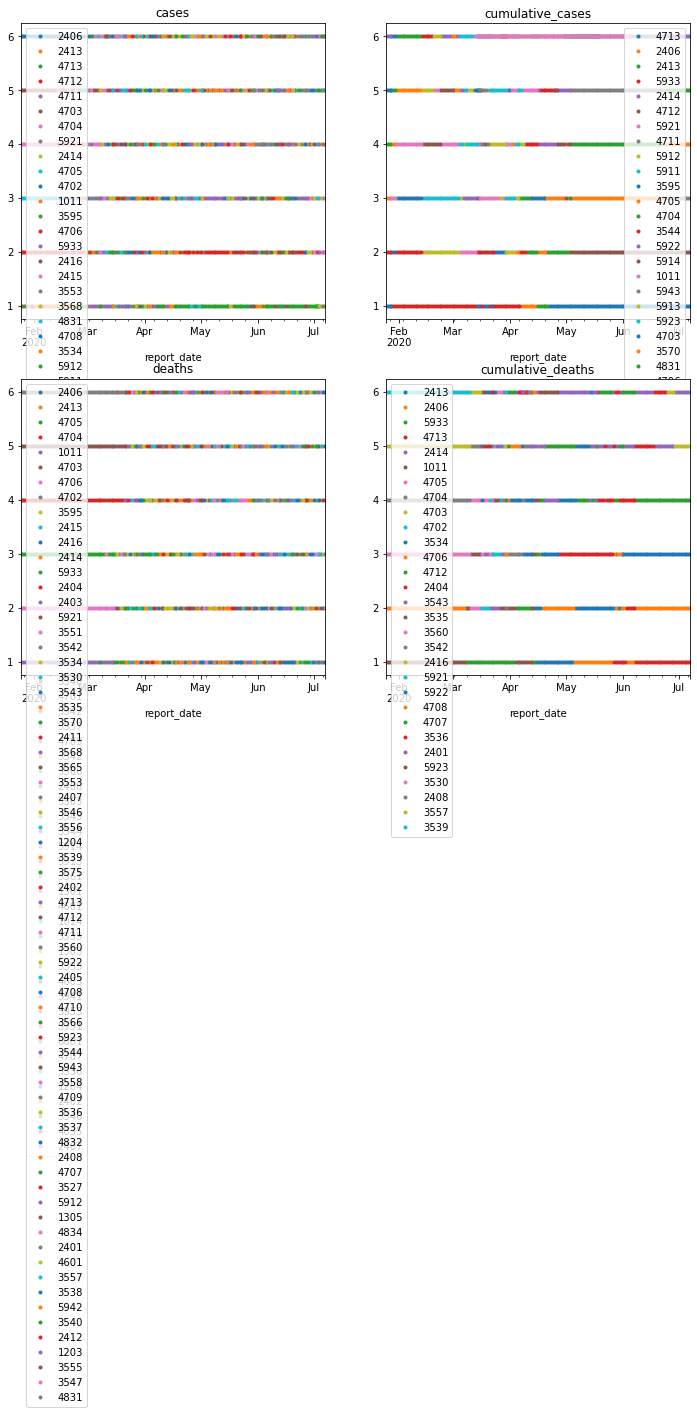

In [52]:
def plot_labels(dfs, columns=[],nzero=True, **kargs):
    fig, axis = plt.subplots(2,2, figsize=(12,12))  # 2 row, 2 columns
    for i, k in enumerate(keys):
        df = dfs[k]
        if columns:
            df = df[columns[k]]
        if nzero:
            df = df.replace(0,np.nan)
        df.plot(title=k,  ax=axis[i // 2 ][i % 2], **kargs)

        
def create_labels(dfs, top, normalize=False, default=None, lookback=True):
    columns = {}
    labels     = {}
    for key in keys:
        
        #get all the columns names except the report_date
        cols = dfs[key].columns[1:].tolist()
        
        labels[key] = dfs[key].copy()
        labels[key] = labels[key][cols].astype('float')

        #order from max to min of the values per day. 
        order        = np.argsort(-dfs[key][cols].values, axis=1)
        #get the column index given the order
        rows         = dfs[key][cols].columns[order]
        #access the indices 
        index        = dfs[key][cols].index 

        #only display health regions that are among the max values
        _display_hruid = []

      
        #iterate over the sorted rows
        for _i, row in enumerate(rows):
            #max_value represent the maximum value for day at index _i
            max_value = labels[key].at[index[_i], row[0]]
            #iterate over the cols of a sorted row
            for _j, col in enumerate(row):
                
                value = labels[key].at[index[_i], col]
                #If it's not a max value, make it zero (no high-risk region)
                if _j > (top - 1):
                    ## if the HR was flagged the previous day as a high Risk
                    # and the number of cases/cum cases has increased, then continue 
                    # its state of high risk (only if lookback is True)
                    # otherwise make all values zero. 
                    
                    value = 0
                    if lookback and \
                         _i > 0 and \
                        labels[key].at[index[_i-1], col] > 0 and \
                        dfs[key].at[index[_i], col] > dfs[key].at[index[_i-1], col]:
                        
                        
                        if normalize and max_value > 0 :
                            value /= float(max_value)
                        elif default is not None and default == 0:
                            value = labels[key].at[index[_i-1], col]
                        elif default > 0:
                            value = default
                else:
                #if it's among the max values display this hr_uid
                    _display_hruid.append(col)

                    if normalize and max_value > 0 :
                        value /= float(max_value)
                    elif default is not None and default == 0:
                        value = _j + 1
                    elif default > 0:
                        value = default
                labels[key].at[index[_i], col] = value
                    
                    

        counter       = Counter(_display_hruid).most_common(100)
        columns[key]  = [hr_uid for hr_uid, count in counter if count > 0] 
    return labels, columns

labels, columns = create_labels(ndfs,6, normalize=False, default=0, lookback=True)
plot_labels(labels, columns=columns, nzero=True,  logy=False,legend=True, style='.')
display_unique_cols(columns)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


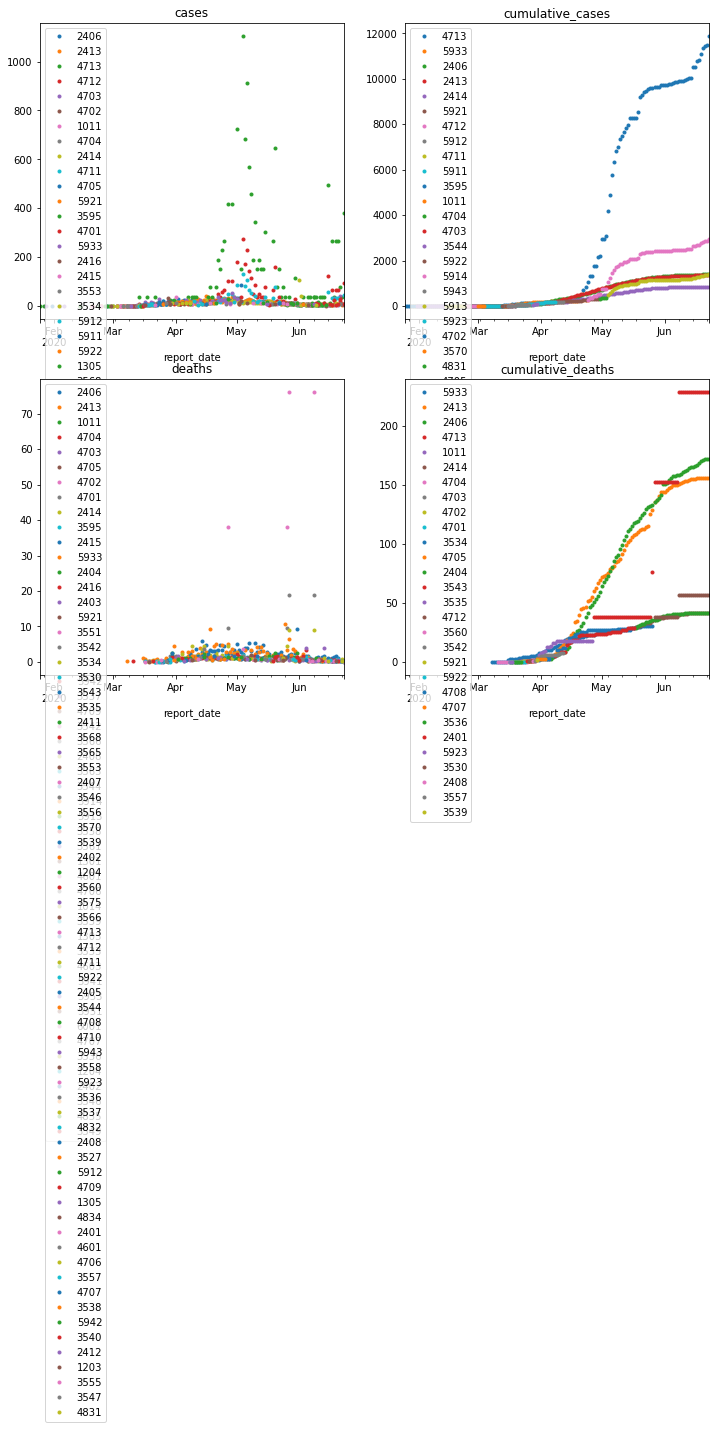

In [440]:
#Plotting the Same results without Lookback
labels, columns = create_labels(ndfs,6, normalize=False, default=None, lookback=False)
plot_labels(labels, columns=columns, nzero=True,  logy=False,legend=True, style='.')
#display_unique_cols(columns)

In [434]:
#save labels to database

def save_to_sqlite(cnx, labels, name='HIGH_RISK_' top=6):
    output = pd.DataFrame(columns=['report_date', 
                                   'HR_UID', 
                                   f't{top}c',
                                   f't{top}cc',
                                   f't{top}d',
                                   f't{top}cd'])

    cdf = labels['cases']
    ccdf= labels['cumulative_cases']
    ddf = labels['deaths']
    cddf= labels['cumulative_deaths']


    count = 0
    for i in cdf.index:
        for j in cdf.columns:
            _i_str = str(i).split()[0]
            output.loc[count]= [_i_str, j, 
                                cdf.at[i, j], 
                                ccdf.at[i, j], 
                                ddf.at[i, j], 
                                cddf.at[i, j]]
            count+=1
    output.to_sql(f'{name}{top}', cnx)
    return output 



In [441]:
import tqdm

index report_date HR_UID  t6c  t6cc  t6d  t6cd
0          0  2020-01-25   1011  0.0   0.0  0.0   0.0
1          1  2020-01-25   1012  0.0   0.0  0.0   0.0
2          2  2020-01-25   1013  0.0   0.0  0.0   0.0
3          3  2020-01-25   1014  0.0   0.0  0.0   0.0
4          4  2020-01-25   1100  0.0   0.0  0.0   0.0
...      ...         ...    ...  ...   ...  ...   ...
16152  16152  2020-06-23   5951  0.0   0.0  0.0   0.0
16153  16153  2020-06-23   5952  0.0   0.0  0.0   0.0
16154  16154  2020-06-23   5953  0.0   0.0  0.0   0.0
16155  16155  2020-06-23   6001  0.0   0.0  0.0   0.0
16156  16156  2020-06-23   6101  0.0   0.0  0.0   0.0

[16157 rows x 7 columns]